In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
from PIL import Image


In [3]:
DATA_DIR = '/content/drive/MyDrive/Dataset_Extracted'
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 10

In [4]:
train_ds = image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
class_names = train_ds.class_names

Found 1762 files belonging to 4 classes.
Using 1410 files for training.


In [5]:
val_ds = image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 1762 files belonging to 4 classes.
Using 352 files for validation.


In [6]:
def prep_fn(x, y):
    x = preprocess_input(x)           # ResNet-specific normalization
    return x, y

In [7]:
train_ds = train_ds.map(prep_fn, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds   = val_ds.map(prep_fn,   num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)



In [8]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
base_model.trainable = False  # freeze base


In [10]:
inputs = keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(4, activation='softmax')(x)  # 4 classes
model = keras.Model(inputs, outputs)


In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 328s 7s/step - accuracy: 0.4025 - loss: 1.4286 - val_accuracy: 0.5284 - val_loss: 1.1062
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 355s 7s/step - accuracy: 0.4979 - loss: 1.1923 - val_accuracy: 0.6193 - val_loss: 0.9819
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 316s 7s/step - accuracy: 0.5502 - loss: 1.0702 - val_accuracy: 0.6506 - val_loss: 0.8980
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 288s 6s/step - accuracy: 0.6131 - loss: 0.9794 - val_accuracy: 0.6960 - val_loss: 0.8370
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 327s 7s/step - accuracy: 0.6217 - loss: 0.9176 - val_accuracy: 0.7244 - val_loss: 0.7947
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 343s 7s/step - accuracy: 0.6731 - loss: 0.8171 - val_accuracy: 0.7415 - val_loss: 0.7587
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 313s 7s/step - accuracy: 0.6915 - loss: 0.8031 - val_accuracy: 0.7528 - val_loss: 0.7318
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 313s 7s/step - accuracy: 0.7023 - loss: 0.7527 - val_accuracy: 0.7642 - v

In [15]:
# prompt: Save the model in pkl and h5 extension on drive in a new directory named as resnet_models

import pickle

# Create the directory if it doesn't exist
model_dir = '/content/drive/MyDrive/resnet_models'
os.makedirs(model_dir, exist_ok=True)

# Save the model in .pkl format
pkl_path = os.path.join(model_dir, 'model.pkl')
with open(pkl_path, 'wb') as f:
    pickle.dump(model, f)
print(f"Model saved successfully to {pkl_path}")


# Save the model in .h5 format
h5_path = os.path.join(model_dir, 'model.h5')
model.save(h5_path)
print(f"Model saved successfully to {h5_path}")

Model saved successfully to /content/drive/MyDrive/resnet_models/model.pkl
Model saved successfully to /content/drive/MyDrive/resnet_models/model.h5


In [ ]:
# prompt: save model using pickle the model has been trained in previous cell

import pickle
pickle.dump(model, open('./my_model.pkl', 'wb'))



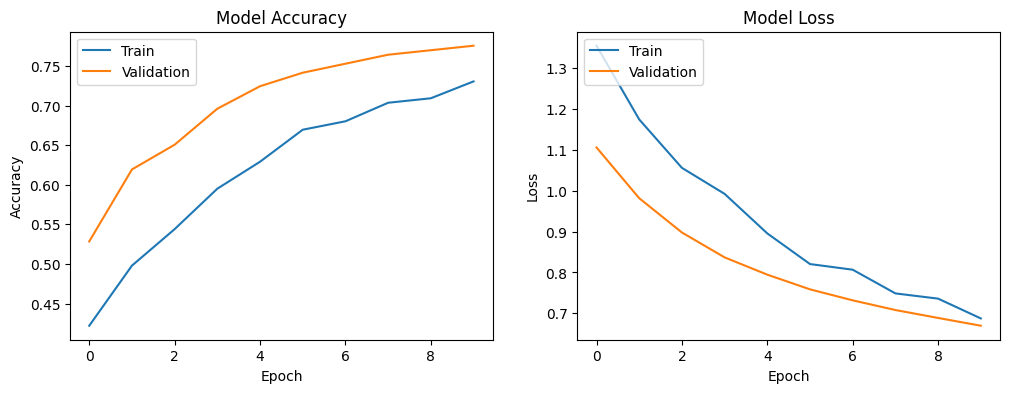

In [14]:
# prompt: plot model traning and all other metrics

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [16]:
base_model.trainable = True
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # lower LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history_fine = model.fit(
    train_ds,
    epochs=4,
    validation_data=val_ds
)

Epoch 1/4
45/45 ━━━━━━━━━━━━━━━━━━━━ 1125s 24s/step - accuracy: 0.6853 - loss: 0.8633 - val_accuracy: 0.6818 - val_loss: 0.7709
Epoch 2/4
45/45 ━━━━━━━━━━━━━━━━━━━━ 1082s 24s/step - accuracy: 0.9077 - loss: 0.2741 - val_accuracy: 0.6619 - val_loss: 0.8101
Epoch 3/4
45/45 ━━━━━━━━━━━━━━━━━━━━ 1083s 24s/step - accuracy: 0.9552 - loss: 0.1627 - val_accuracy: 0.7074 - val_loss: 0.8185
Epoch 4/4
45/45 ━━━━━━━━━━━━━━━━━━━━ 1106s 24s/step - accuracy: 0.9692 - loss: 0.1085 - val_accuracy: 0.8011 - val_loss: 0.5777


In [17]:
# prompt: save this model as 96_acc_resnet in the same folder in the drive

# Save the model in .h5 format with the specified name
h5_path_96_acc = os.path.join('/content/drive/MyDrive/', '96_acc_resnet.h5')
model.save(h5_path_96_acc)
print(f"Model saved successfully to {h5_path_96_acc}")

# You could also save the final fine-tuned model as a separate file if needed
# history_fine_tuned = model.fit(...) # Assuming you continued training
# h5_path_fine_tuned = os.path.join('/content/drive/MyDrive/', 'fine_tuned_resnet.h5')
# model.save(h5_path_fine_tuned)
# print(f"Fine-tuned model saved successfully to {h5_path_fine_tuned}")

Model saved successfully to /content/drive/MyDrive/96_acc_resnet.h5


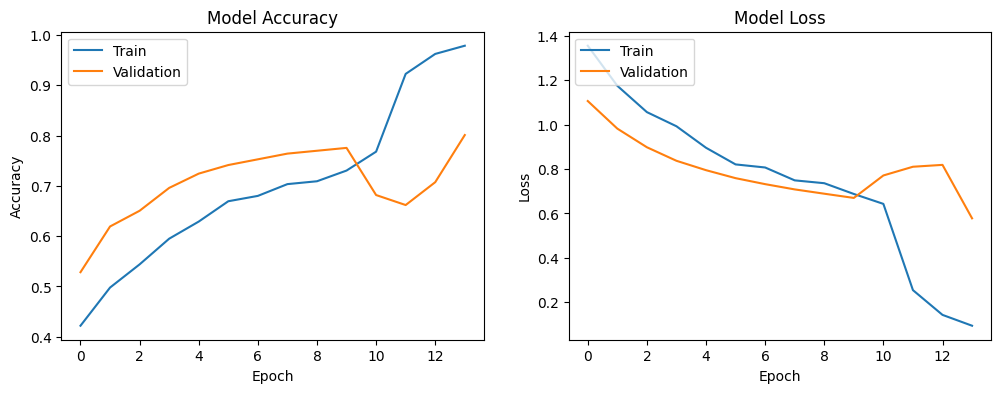

In [19]:
# prompt: plot model traning and all other metrics

import matplotlib.pyplot as plt
# Combine history from both training phases
history_combined = {}
for key in history.history.keys():
  history_combined[key] = history.history[key] + history_fine.history[key]

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_combined['accuracy'])
plt.plot(history_combined['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_combined['loss'])
plt.plot(history_combined['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


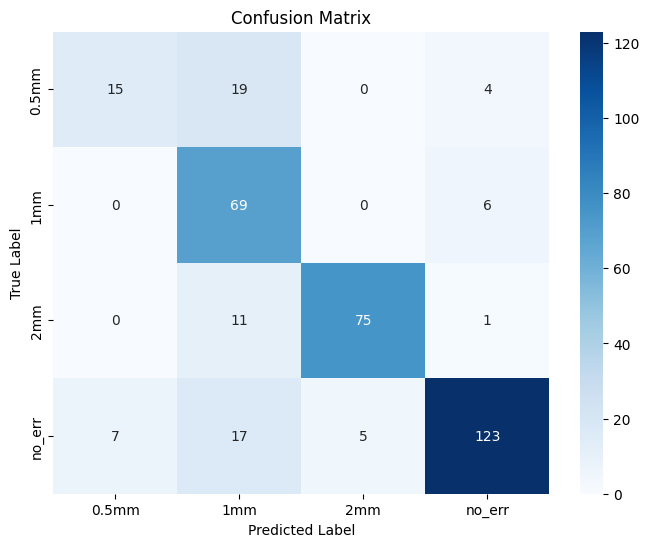


Classification Report:
              precision    recall  f1-score   support

       0.5mm       0.68      0.39      0.50        38
         1mm       0.59      0.92      0.72        75
         2mm       0.94      0.86      0.90        87
      no_err       0.92      0.81      0.86       152

    accuracy                           0.80       352
   macro avg       0.78      0.75      0.75       352
weighted avg       0.83      0.80      0.80       352



In [20]:
# prompt: make confusion metrix and report evaluation report

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get true labels and predictions for the validation dataset
val_labels = []
val_predictions = []

for images, labels in val_ds:
    val_labels.extend(np.argmax(labels.numpy(), axis=1))
    val_predictions.extend(np.argmax(model.predict(images), axis=1))

# Generate Confusion Matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate Classification Report
print("\nClassification Report:")
print(classification_report(val_labels, val_predictions, target_names=class_names))

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/err_resnet_tf.keras'  # Added .keras extension
model.save(MODEL_PATH)

In [ ]:

def predict_image_tf(img_path, model, target_size=IMG_SIZE):
    img = Image.open(img_path).convert('RGB').resize(target_size)
    arr = np.array(img)[None, ...]
    arr = preprocess_input(arr)
    preds = model.predict(arr)
    idx = np.argmax(preds, axis=1)[0]
    return class_names[idx], float(preds[0, idx])

# Example
sample_path = '/content/drive/MyDrive/ERR_dataset/1mm/Scr1B222025-05-09_20-13-03.png'
label, confidence = predict_image_tf(sample_path, model)
print(f'Predicted: {label} ({confidence*100:.1f}%)')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted: 1mm (48.4%)


In [ ]:
import pickle

metadata = {
    'class_names': class_names,
    'IMG_SIZE': IMG_SIZE
}

with open('/content/drive/MyDrive/err_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)


In [ ]:
# 1️⃣ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2️⃣ Imports
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import shutil

# 3️⃣ Source and destination directories
SOURCE_DIR = '/content/drive/MyDrive/ERR_dataset'
DEST_DIR = '/content/drive/MyDrive/ERR_dataset_preprocessed'

# Recreate folder structure
if os.path.exists(DEST_DIR):
    shutil.rmtree(DEST_DIR)
os.makedirs(DEST_DIR)

for class_name in os.listdir(SOURCE_DIR):
    os.makedirs(os.path.join(DEST_DIR, class_name), exist_ok=True)

# 4️⃣ Preprocessing Functions

def extract_tooth_roi(image):
    """Extract the largest contour assuming it's the tooth."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(
        thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return image  # fallback

    # Get largest contour by area
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    roi = image[y:y+h, x:x+w]
    return roi

def apply_clahe(image):
    """Apply CLAHE to the L-channel in LAB color space."""
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)

def normalize_intensity(image):
    """Adjust intensity to full [0,255] range."""
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

def process_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    image = extract_tooth_roi(image)
    image = apply_clahe(image)
    image = normalize_intensity(image)
    image = cv2.resize(image, (224, 224))  # Resize to match ResNet input
    return image

# 5️⃣ Apply preprocessing to all images
for class_name in tqdm(os.listdir(SOURCE_DIR), desc="Processing folders"):
    src_folder = os.path.join(SOURCE_DIR, class_name)
    dst_folder = os.path.join(DEST_DIR, class_name)

    for img_path in glob(os.path.join(src_folder, "*")):
        img_name = os.path.basename(img_path)
        output_path = os.path.join(dst_folder, img_name)

        processed_img = process_image(img_path)
        if processed_img is not None:
            cv2.imwrite(output_path, processed_img)


Mounted at /content/drive


Processing folders: 100%|██████████| 4/4 [02:17<00:00, 34.35s/it]


In [ ]:
# ✅ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ✅ Imports
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import shutil

# ✅ Define source and destination directories
SOURCE_DIR = '/content/drive/MyDrive/ERR_dataset'  # <-- change if needed
DEST_DIR = '/content/drive/MyDrive/ERR_dataset_preprocessed_without_noise'

# ✅ Prepare output folders (delete if already exists)
if os.path.exists(DEST_DIR):
    shutil.rmtree(DEST_DIR)
os.makedirs(DEST_DIR)

for class_name in os.listdir(SOURCE_DIR):
    os.makedirs(os.path.join(DEST_DIR, class_name), exist_ok=True)

# ✅ Preprocessing functions
def extract_tooth_roi(image):
    """Extract the largest contour assuming it's the tooth."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(
        thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return image  # fallback

    # Get largest contour by area
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    roi = image[y:y+h, x:x+w]
    return roi
"""
def extract_clean_tooth_roi(image):

  #  Extract tooth ROI even with white noise and unclear boundaries.
    image_blur = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
    gray = cv2.cvtColor(image_blur, cv2.COLOR_BGR2GRAY)

    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 2
    )

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return image  # fallback

    height, width = gray.shape
    image_area = height * width

    best_contour = None
    best_area = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if image_area * 0.01 < area < image_area * 0.95:
            x, y, w, h = cv2.boundingRect(cnt)
            aspect_ratio = w / float(h)
            if 0.3 < aspect_ratio < 1.5 and area > best_area:
                best_area = area
                best_contour = cnt

    if best_contour is None:
        return image

    x, y, w, h = cv2.boundingRect(best_contour)
    return image[y:y+h, x:x+w]
"""
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)

def normalize_intensity(image):
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

def process_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    image = extract_tooth_roi(image)
    image = apply_clahe(image)
    image = normalize_intensity(image)
    image = cv2.resize(image, (224, 224))
    return image


# ✅ Preprocess all images
for class_name in tqdm(os.listdir(SOURCE_DIR), desc="Processing folders"):
    src_folder = os.path.join(SOURCE_DIR, class_name)
    dst_folder = os.path.join(DEST_DIR, class_name)

    for img_path in glob(os.path.join(src_folder, "*")):
        img_name = os.path.basename(img_path)
        output_path = os.path.join(dst_folder, img_name)

        processed_img = process_image(img_path)
        if processed_img is not None:
            cv2.imwrite(output_path, processed_img)

print("✅ Preprocessing complete. Output saved to:", DEST_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Processing folders: 100%|██████████| 4/4 [01:20<00:00, 20.11s/it]

✅ Preprocessing complete. Output saved to: /content/drive/MyDrive/ERR_dataset_preprocessed_without_noise


In [ ]:
import os
import cv2
import numpy as np

# === Preprocessing functions ===

def normalize_intensity(image):
    normalized = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    return normalized.astype(np.uint8)

def apply_histogram_equalization(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(image)
    return equalized

def apply_adaptive_thresholding(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresholded = cv2.adaptiveThreshold(
        image,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY,
        blockSize=11,
        C=2
    )
    return thresholded

def apply_clahe(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    return clahe_image

def crop_tooth_region(image, padding=20):
    """
    Crops the region containing the tooth with a margin around it.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image.copy()
    norm_img = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
    _, thresh = cv2.threshold(norm_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return image  # fallback to original

    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    height, width = gray.shape
    x1 = max(x - padding, 0)
    y1 = max(y - padding, 0)
    x2 = min(x + w + padding, width)
    y2 = min(y + h + padding, height)

    cropped = image[y1:y2, x1:x2]
    return cropped

# === Directory paths ===

input_root = 'err_dataset'
output_root = 'processed_err_dataset'
os.makedirs(output_root, exist_ok=True)

# === Processing all images ===

for label_folder in os.listdir(input_root):
    input_label_path = os.path.join(input_root, label_folder)
    output_label_path = os.path.join(output_root, label_folder)
    os.makedirs(output_label_path, exist_ok=True)

    if not os.path.isdir(input_label_path):
        continue

    for filename in os.listdir(input_label_path):
        input_image_path = os.path.join(input_label_path, filename)
        output_image_path = os.path.join(output_label_path, filename)

        # Read image
        image = cv2.imread(input_image_path)
        if image is None:
            print(f"Failed to read {input_image_path}, skipping.")
            continue

        # === Apply preprocessing pipeline ===
        try:
            img = crop_tooth_region(image)
            img = normalize_intensity(img)
            img = apply_histogram_equalization(img)
            img = apply_adaptive_thresholding(img)
            img = apply_clahe(img)

            # Save processed image
            cv2.imwrite(output_image_path, img)
            print(f"Processed and saved: {output_image_path}")
        except Exception as e:
            print(f"Error processing {input_image_path}: {e}")


In [ ]:
# === Mount Google Drive and process dental images in one cell ===

from google.colab import drive
import os
import cv2
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

# === Preprocessing functions ===

def normalize_intensity(image):
    normalized = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    return normalized.astype(np.uint8)

def apply_histogram_equalization(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(image)
    return equalized

def apply_adaptive_thresholding(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresholded = cv2.adaptiveThreshold(
        image,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY,
        blockSize=11,
        C=2
    )
    return thresholded

def apply_clahe(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    return clahe_image

def crop_tooth_region(image, padding=20):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image.copy()
    norm_img = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
    _, thresh = cv2.threshold(norm_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return image

    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    height, width = gray.shape
    x1 = max(x - padding, 0)
    y1 = max(y - padding, 0)
    x2 = min(x + w + padding, width)
    y2 = min(y + h + padding, height)

    cropped = image[y1:y2, x1:x2]
    return cropped

# === Define paths ===

input_root = '/content/drive/MyDrive/ERR_dataset'
output_root = '/content/drive/MyDrive/processed_err_dataset'
os.makedirs(output_root, exist_ok=True)

# === Process all images ===

for label_folder in os.listdir(input_root):
    input_label_path = os.path.join(input_root, label_folder)
    output_label_path = os.path.join(output_root, label_folder)
    os.makedirs(output_label_path, exist_ok=True)

    if not os.path.isdir(input_label_path):
        continue

    for filename in os.listdir(input_label_path):
        input_image_path = os.path.join(input_label_path, filename)
        output_image_path = os.path.join(output_label_path, filename)

        image = cv2.imread(input_image_path)
        if image is None:
            print(f"Failed to read {input_image_path}, skipping.")
            continue

        try:
            img = crop_tooth_region(image)
            img = normalize_intensity(img)
            img = apply_histogram_equalization(img)
            img = apply_adaptive_thresholding(img)
            img = apply_clahe(img)

            cv2.imwrite(output_image_path, img)
            print(f"Processed and saved: {output_image_path}")
        except Exception as e:
            print(f"Error processing {input_image_path}: {e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processed and saved: /content/drive/MyDrive/processed_err_dataset/0.5mm/Scr2E9E2025-05-10_11-52-29.png
Processed and saved: /content/drive/MyDrive/processed_err_dataset/0.5mm/ScrCF4E2025-05-10_11-49-54.png
Processed and saved: /content/drive/MyDrive/processed_err_dataset/0.5mm/ScrB7C42025-05-10_11-39-58.png
Processed and saved: /content/drive/MyDrive/processed_err_dataset/0.5mm/ScrAF282025-05-10_11-39-56.png
Processed and saved: /content/drive/MyDrive/processed_err_dataset/0.5mm/Scr2B8D2025-05-10_11-47-01.png
Processed and saved: /content/drive/MyDrive/processed_err_dataset/0.5mm/Scr4BFD2025-05-10_11-52-37.png
Processed and saved: /content/drive/MyDrive/processed_err_dataset/0.5mm/ScrE2962025-05-10_11-43-25.png
Processed and saved: /content/drive/MyDrive/processed_err_dataset/0.5mm/ScrD1CB2025-05-10_11-43-21.png
Processed and saved: /content/drive/MyDrive/pro